In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
wordcloud_stopwords = set(STOPWORDS)

from tqdm import tqdm
from ufal.udpipe import Model, Pipeline, ProcessingError
import conllu
from nltk.corpus import stopwords
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
m = Model.load("english-gum-ud-2.5-191206.udpipe")
pipeline_tokenize = Pipeline(m, 'tokenize', Pipeline.DEFAULT, Pipeline.NONE, 'conllu')
error = ProcessingError()

In [4]:
df = pd.read_csv('Shoes_Data.csv')
df['float_price'] = [float(df['price'].loc[i][1:]) for i in range(len(df['price']))]
df['float_rating'] = [float(df['rating'].loc[i][:-15]) for i in range(len(df['rating']))]

In [5]:
joined_reviews = df['reviews']
joined_ratings = df['reviews_rating']
reviews_nested = [reviews.split('|| ') for reviews in joined_reviews]
ratings_nested = [ratings.split('|| ') for ratings in joined_ratings]
ratings = [float(item[:3]) for r in ratings_nested for item in r]

In [6]:
df['individual_reviews'] = reviews_nested
df = df.explode('individual_reviews')
df['individual_ratings'] = ratings

### Анализ данных

In [7]:
# individual_ratings - интересующие нас данные
df.describe()

,float_price,float_rating,individual_ratings
count,9958.000000,9958.000000,9958.000000
mean,1930.607878,3.996224,3.772645
std,1631.601658,0.355258,1.527403
min,127.000000,1.000000,1.000000
25%,622.000000,3.800000,3.000000
50%,1507.000000,4.000000,4.000000
75%,2699.000000,4.200000,5.000000
max,7992.000000,5.000000,5.000000


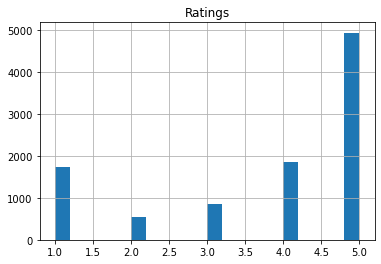

In [8]:
# распределение классов
df['individual_ratings'].hist(bins=20)
plt.title('Ratings')
plt.show()

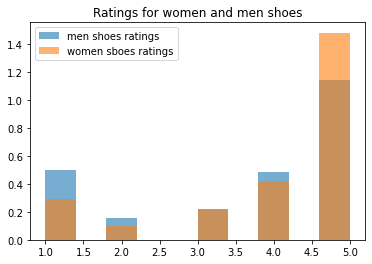

In [9]:
men_prices = df[df['Shoe Type'] == 'Men']['individual_ratings']
women_prices = df[df['Shoe Type'] == 'Women']['individual_ratings']

plt.hist(men_prices, alpha=0.6, density=True, label='men shoes ratings')
plt.hist(women_prices, alpha=0.6, density=True, label='women sboes ratings')
plt.legend()
plt.title('Ratings for women and men shoes')
plt.show()

#### Два графика выше показывают, что
* Классы не сбалансированы - класс с отличными отзывами (5) самый большой. Возможно, нужно будет попробовать сбалансировать классы.
* На мужскую обувь больше плохих оценок, чем на женскую. На женскую больше отличных оценок, чем на мужскую. Разница не кажется настолько значительной, чтобы добавлять пол в признаки. 

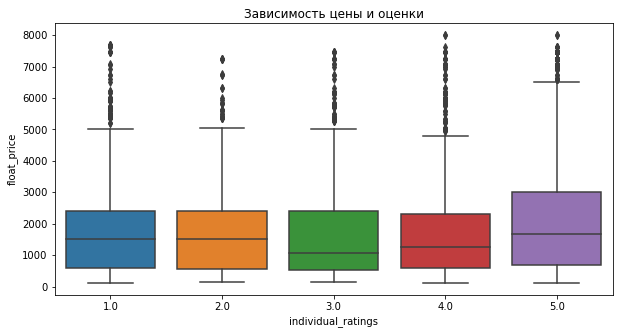

In [10]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='individual_ratings', y='float_price')
plt.title('Зависимость цены и оценки')
plt.show()

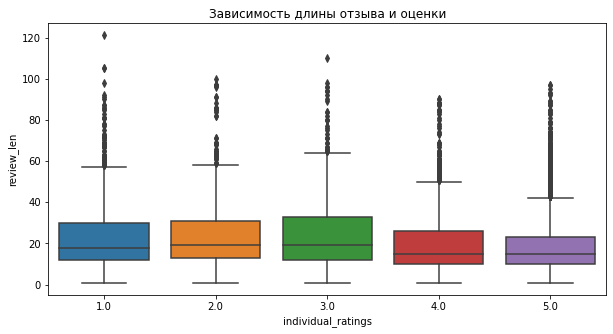

In [11]:
review_lens = [len(df['individual_reviews'].iloc[i]) for i in range(len(df['individual_reviews']))]
df['review_len'] = review_lens

plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='individual_ratings', y='review_len')
plt.title('Зависимость длины отзыва и оценки')
plt.show()

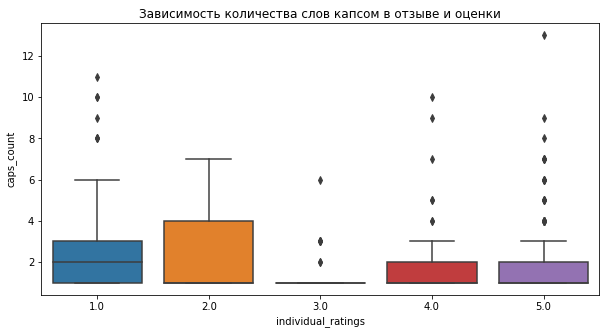

In [12]:
upper_words_counts = []
for desc in df['individual_reviews']:
    words = desc.split(' ')
    count = 0
    for word in words:
        if word.isupper():
            count += 1
    upper_words_counts.append(count)
    
df['caps_count'] = upper_words_counts
plt.figure(figsize=(10,5))
sns.boxplot(data=df[df['caps_count'] != 0], x='individual_ratings', y='caps_count')
plt.title('Зависимость количества слов капсом в отзыве и оценки')
plt.show()

#### Боксплоты выше показывают, что
* Обувь с оценкой 5 чаще оказывается дороже, чем обувь с другими оценками. Но в целом разница в цене между классами не очень различается.
* Отзывы к оценкам 5 немного короче, чем остальные, но другие оценки опять же не имеют больших различий.
* Слова капсом реже всего встречаются в нейтральных отзывах с оценкой 3, а чаще в негативных отзывах с оценками 1-2.

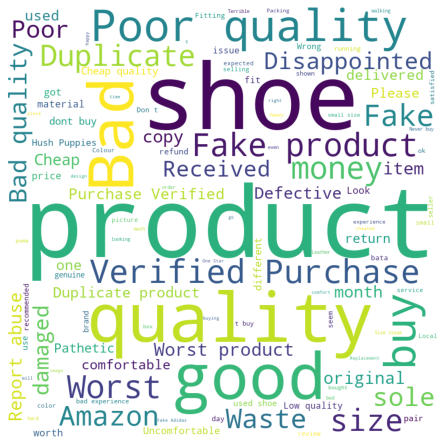

In [13]:
bad_reviews = df[df['individual_ratings'] == 1]['individual_reviews'].to_list()
bad_reviews_str = ' '.join(bad_reviews)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = wordcloud_stopwords,
                min_font_size = 8).generate(bad_reviews_str)
 
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

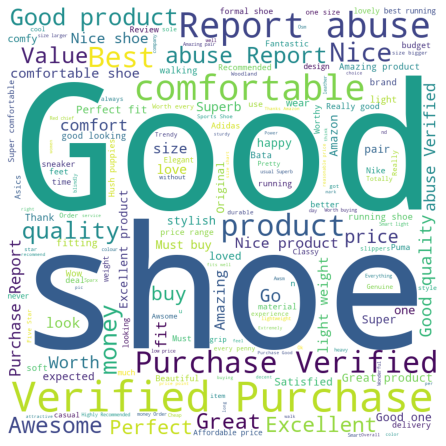

In [14]:
good_reviews = df[df['individual_ratings'] == 5]['individual_reviews'].to_list()
good_reviews_str = ' '.join(good_reviews)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = wordcloud_stopwords,
                min_font_size = 8).generate(good_reviews_str)
 
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

#### На вордклаудах выше видно, что 
* Плохие (1) и отличные (5) отзывы неплохо различаются по своему лексикону.
* Однако основная проблема скорее всего будет не в различении классов 1 и 5, а в различении классов между ними.

### Подготовка данных
* Лемматизация, удаление стоп-слов и пунктуации, приведение к нижнему регистру - все по тем же причинам, что и в 1 задании. 
* Векторизация с помощью tf-idf. Количество признаков не ограничиваю - экспериментальным способов выяснила, что так качество лучше. Для векторизации использую униграммы и биграммы, потому что в негативных отзывах могут встречаться положительные слова с отрицанием типа "not comfortable"

In [15]:
def lemmatize(text, drop_punct=False):
    if error.occurred():
        print(error.message)
    conllu_text = pipeline_tokenize.process(text, error)
    sentences = conllu.parse(conllu_text)
    lemmas = []
    for sent in sentences:
        for token in sent:
            if drop_punct:
                if token['upos'] == 'PUNCT':
                    continue
            lemmas.append(token['lemma'])
    return lemmas

In [16]:
lemmas = []
for review in tqdm(df['individual_reviews']):
    curr_lemmas = lemmatize(review, drop_punct=True)
    clean_lemmas = [lemma.lower() for lemma in curr_lemmas if lemma.lower() not in stop_words]
    lemmas.append(clean_lemmas)

100%|████████████████████████████████████████████████████████████████████████████| 9958/9958 [00:04<00:00, 2202.08it/s]


In [17]:
# векторизуем
lemmatized = [' '.join(lemmas) for lemmas in lemmas]
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidf = vectorizer.fit_transform(lemmatized)

In [18]:
# объединяем в датафрейм, делим на трейн и тест
features_df = pd.DataFrame(tfidf.toarray())
df = df.reset_index()
full_df = pd.concat([df, features_df], axis=1)
train, test = train_test_split(full_df, test_size=0.2, random_state=42)

#### Попробуем векторизовать еще и с помощью CountVectorizer
* На одной LogisticRegression с базовыми гиперпараметрами убедимся, что Tf-Idf лучше отображает текст и не будем тратить время, чтобы сделать Grid Search на 5 моделях для текстов с обоими способами векторизации - далее используется только Tf-Idf

In [19]:
сount_vectorizer = CountVectorizer()
count = сount_vectorizer.fit_transform(lemmatized)
features_df_count = pd.DataFrame(count.toarray())
full_df_count = pd.concat([df, features_df_count], axis=1)
train_count, test_count = train_test_split(full_df_count, test_size=0.2, random_state=42)

In [24]:
logreg = LogisticRegression(max_iter=200)
model = logreg.fit(train_count[list(features_df_count.columns)], train_count['individual_ratings'])
pred = model.predict(test_count[list(features_df_count.columns)])
print(f"Accuracy with CountVectorizer: {accuracy_score(pred, test_count['individual_ratings'])}")

Accuracy with CountVectorizer: 0.643574297188755


In [25]:
logreg = LogisticRegression(max_iter=200)
model = logreg.fit(train[list(features_df.columns)], train['individual_ratings'])
pred = model.predict(test[list(features_df.columns)])
print(f"Accuracy with TfIdfVectorizer: {accuracy_score(pred, test['individual_ratings'])}")

Accuracy with TfIdfVectorizer: 0.6541164658634538


### Еще анализ данных
Теперь когда у нас есть векторное представление слов, попробуем кластеризовать данные по ним. Сделаем tsne. Оно показало, что красные (плохие) отзывы иногда собираются в одну кучку, так же как и фиолетовые (хорошие), но есть большой кластер, в котором смешаны различные отзывы. Возможно, классификация не выйдет такой хорошей, как хотелось бы.

In [82]:
pca = PCA(n_components=30)
pca_result = pca.fit_transform(tfidf.toarray())
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 

In [85]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result)

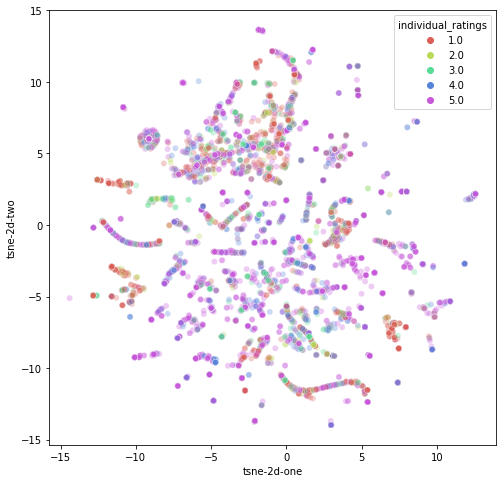

In [91]:
df['tsne-2d-one'] = tsne_pca_results[:,0]
df['tsne-2d-two'] = tsne_pca_results[:,1]
plt.figure(figsize=(8,8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='individual_ratings',
    palette=sns.color_palette("hls", 5),
    data=df,
    legend="full",
    alpha=0.3
)
plt.show()

### GridSearch
* Пробую 5 моделей

In [22]:
model = LogisticRegression()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
space = dict()
# space['solver'] = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
# space['penalty'] = ['l2']
# space['fit_intercept'] = [True, False]
# space['C'] = [100, 10, 1.0, 0.1, 0.01]
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['C'] = [100, 10, 1.0, 0.1, 0.01]
space['max_iter'] = [150]
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv, verbose=2)
result = search.fit(train[list(features_df.columns)], train['individual_ratings'])
print('Logistic Regression')
print('Best Accuracy: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 30 folds for each of 15 candidates, totalling 450 fits
Logistic Regression
Best Accuracy: 0.6230636663030754
Best Hyperparameters: {'C': 1.0, 'max_iter': 150, 'solver': 'newton-cg'}


In [28]:
model = KNeighborsClassifier()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
space = dict()
space['n_neighbors'] = [20, 22, 25, 30, 35, 40, 50]
space['weights'] = ['uniform', 'distance']
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv, verbose=2)
result = search.fit(train[list(features_df.columns)], train['individual_ratings'])
print('K Neighbors Classifier')
print('Best Accuracy: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 30 folds for each of 14 candidates, totalling 420 fits
K Neighbors Classifier
Best Accuracy: 0.6126440441437636
Best Hyperparameters: {'n_neighbors': 30, 'weights': 'distance'}


In [29]:
model = MultinomialNB()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
space = dict()
space['alpha'] = np.linspace(0.5, 1.5, 6)
space['fit_prior'] = [True, False]
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv, verbose=2)
result = search.fit(train[list(features_df.columns)], train['individual_ratings'])
print('Multinomial Naive Bayes')
print('Best Accuracy: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 30 folds for each of 12 candidates, totalling 360 fits
Multinomial Naive Bayes
Best Accuracy: 0.6203020539754398
Best Hyperparameters: {'alpha': 0.9, 'fit_prior': True}


In [31]:
model = DecisionTreeClassifier()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
space = dict()
space['criterion'] = ['gini', 'entropy']
space['max_leaf_nodes'] = range(10, 150, 10)
space['min_samples_split'] = [2, 3, 4]
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv, verbose=2)
result = search.fit(train[list(features_df.columns)], train['individual_ratings'])
print('Decision Tree Classifier')
print('Best Accuracy: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 30 folds for each of 84 candidates, totalling 2520 fits
Decision Tree Classifier
Best Accuracy: 0.5988362452160426
Best Hyperparameters: {'criterion': 'gini', 'max_leaf_nodes': 140, 'min_samples_split': 3}


In [32]:
model = LinearSVC()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
space = dict()
space['C'] = [100, 10, 1.0, 0.1, 0.01]
space['fit_intercept'] = [True, False]
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv, verbose=2)
result = search.fit(train[list(features_df.columns)], train['individual_ratings'])
print('Linear SVC')
print('Best Accuracy: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 30 folds for each of 10 candidates, totalling 300 fits
Linear SVC
Best Accuracy: 0.6196741759823794
Best Hyperparameters: {'C': 0.1, 'fit_intercept': True}


### Анализ результатов лучшей модели

Лучшие результаты показала логистическая регрессия. Используем лучшие параметры и обучим снова.

In [21]:
logreg = LogisticRegression(C=1.0, max_iter=150, solver='newton-cg')
best_model = logreg.fit(train[list(features_df.columns)], train['individual_ratings'])
pred = best_model.predict(test[list(features_df.columns)])
print(f"Accuracy of LogReg with best params: {accuracy_score(pred, test['individual_ratings'])}")

Accuracy of LogReg with best params: 0.6541164658634538


Как мы помним, классы в датасете не сбалансированы, поэтому правильнее будет посчитать сбалансированную точность. Еще посчитаем другие метрики для небинарной классификации.

In [23]:
print(f"Balanced accuracy: {balanced_accuracy_score(pred, test['individual_ratings'])}")
micro_f1 = f1_score(pred, test['individual_ratings'], average = 'micro')
micro_p = precision_score(pred, test['individual_ratings'], average = 'micro')
micro_r = recall_score(pred, test['individual_ratings'], average = 'micro')
macro_f1 = f1_score(pred, test['individual_ratings'], average = 'macro')
macro_p = precision_score(pred, test['individual_ratings'], average = 'macro')
macro_r = recall_score(pred, test['individual_ratings'], average = 'macro')
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

Balanced accuracy: 0.703078939595333
micro F1=0.6541, micro P=0.6541, micro R=0.6541
macro F1=0.4161, macro P=0.4072, macro R=0.7031



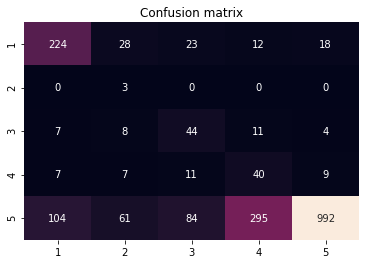

In [24]:
categories = [1, 2, 3, 4, 5]
sns.heatmap(data=confusion_matrix(pred, test['individual_ratings']), annot=True, fmt="d", cbar=False, xticklabels=categories, yticklabels=categories)
plt.title("Confusion matrix")
plt.show()

#### Матрица выше показывает, что 
* Классы 1 и 5 распределяются неплохо, но модель очень склонна все классы относить к классу 5. Этот класс в данных был самым большим.
* Попробуем все-таки сбалансировать классы двумя способами - просто уберем часть класса 5 из датасета или добавим веса в логистическую регрессию.

#### Сначала попробуем добавить классификатору параметр class_weight='balanced', чтобы  он сам подобрал веса для классов

In [26]:
logreg = LogisticRegression(C=1.0, max_iter=150, solver='newton-cg', class_weight='balanced')
best_model = logreg.fit(train[list(features_df.columns)], train['individual_ratings'])
pred = best_model.predict(test[list(features_df.columns)])
print(f"Accuracy of balanced LogReg: {accuracy_score(pred, test['individual_ratings'])}")
print(f"Balanced accuracy of balanced LogReg: {balanced_accuracy_score(pred, test['individual_ratings'])}")

Accuracy of balanced LogReg: 0.5587349397590361
Balanced accuracy of balanced LogReg: 0.4716966919236293


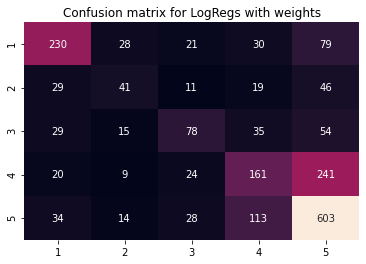

In [27]:
categories = [1, 2, 3, 4, 5]
sns.heatmap(data=confusion_matrix(pred, test['individual_ratings']), annot=True, fmt="d", cbar=False, xticklabels=categories, yticklabels=categories)
plt.title("Confusion matrix for LogRegs with weights")
plt.show()

Диагональ на матрице смежности начала прорисовываться чуть более четко, однако точность значительно упала. 

#### Теперь вырежем кусочек данных с оценкой 5

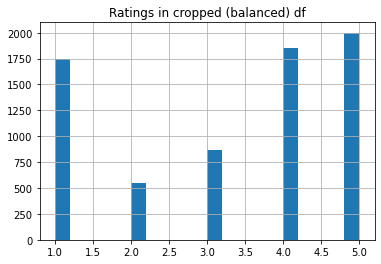

In [28]:
balanced_df = pd.concat([df[df['individual_ratings'] != 5], df[df['individual_ratings'] == 5][:2000]])
balanced_df['individual_ratings'].hist(bins=20)
plt.title('Ratings in cropped (balanced) df')
plt.show()

In [29]:
lemmas = []
for review in tqdm(balanced_df['individual_reviews']):
    curr_lemmas = lemmatize(review, drop_punct=True)
    clean_lemmas = [lemma.lower() for lemma in curr_lemmas if lemma.lower() not in stop_words]
    lemmas.append(clean_lemmas)

100%|████████████████████████████████████████████████████████████████████████████| 7014/7014 [00:06<00:00, 1124.61it/s]


In [30]:
lemmatized = [' '.join(lemmas) for lemmas in lemmas]
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidf = vectorizer.fit_transform(lemmatized)

features_df = pd.DataFrame(tfidf.toarray())
balanced_df = balanced_df.reset_index()
full_df = pd.concat([balanced_df, features_df], axis=1)
train, test = train_test_split(full_df, test_size=0.2, random_state=42)

In [32]:
logreg = LogisticRegression(C=1.0, max_iter=150, solver='newton-cg')
best_model = logreg.fit(train[list(features_df.columns)], train['individual_ratings'])
pred = best_model.predict(test[list(features_df.columns)])
print(f"Accuracy of LogReg with balanced data: {accuracy_score(pred, test['individual_ratings'])}")
print(f"Balanced accuracy of LogRed with balanced data: {balanced_accuracy_score(pred, test['individual_ratings'])}")

Accuracy of LogReg with balanced data: 0.5388453314326443
Balanced accuracy of LogRed with balanced data: 0.5142633421234205


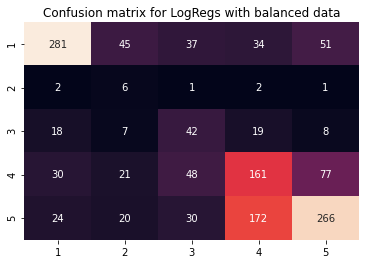

In [33]:
categories = [1, 2, 3, 4, 5]
sns.heatmap(data=confusion_matrix(pred, test['individual_ratings']), annot=True, fmt="d", cbar=False, xticklabels=categories, yticklabels=categories)
plt.title("Confusion matrix for LogRegs with balanced data")
plt.show()

По матрице и упавшей точности видно, что урезание датасета плохо помогло. Теперь все классы ошибочно отправляются в 1 класс, а 4 класс очень сильно путается с 5.